In [1]:
import numpy as np
import pandas as pd

In [2]:
from sklearn.metrics import roc_auc_score

In [3]:
from random import shuffle

Загрузим преобразованные данные

In [4]:
data = pd.read_csv("Data_transformed.csv")

In [5]:
data.head(5)

,Number,Глюкоза,Мочевина,Креатинин,Мочевая к-та,Холестерин,Х-ЛПВП,Х-ЛПНП,Триглицериды,индекс массы тела,...,АТ к Анг II,АТ к ЭТ,АТ к HLDF- 24,Target,phys,mind,age,male,female,no_spec_gender
0,2.0,6.2,5.9,110,443,6.2,1.07,4.25,2.37,20.00,...,NaN,NaN,NaN,-1,3,0,63.0,1,0,0
1,3.0,5.2,5.0,72,164,5.5,2.27,3.39,0.64,20.69,...,NaN,NaN,NaN,-1,1,2,57.0,0,1,0
2,4.0,5.1,5.8,85,345,6.6,2.10,4.14,0.36,30.47,...,NaN,NaN,NaN,-1,1,2,57.0,0,0,1
3,5.0,5.6,5.7,74,438,6.3,1.04,3.96,3.38,31.80,...,1600.0,400.0,50.0,-1,1,1,55.0,1,0,0
4,12.0,5.7,5.5,88,286,7.1,0.91,5.33,1.80,26.50,...,400.0,600.0,100.0,-1,3,0,60.0,1,0,0


Разобьём случайным образом выборку на train и test для дальнейших манипуляций. В силу малого размера самой выборки, воспользуемся кросс-валидацией на 4 фолда

In [6]:
from sklearn.model_selection import KFold

In [7]:
folds = KFold(n_splits = 4, shuffle = True, random_state = 451)

In [8]:
folds.get_n_splits(data)

4

In [9]:
for train_index, test_index in folds.split(data):
    print("Train: ", train_index)
    print("Test: ", test_index)

Train:  [  0   1   2   3   4   6   9  11  13  14  15  17  18  19  20  22  24  25
  27  28  29  30  31  33  34  35  36  37  40  41  42  43  44  45  46  47
  48  50  52  53  54  55  57  58  60  62  63  64  65  66  67  68  69  70
  73  74  75  76  77  78  79  81  82  84  85  87  89  91  92  94  95  96
  97  98  99 100 101 102 103 106 107 108 112 113 114 115 116]
Test:  [  5   7   8  10  12  16  21  23  26  32  38  39  49  51  56  59  61  71
  72  80  83  86  88  90  93 104 105 109 110 111]
Train:  [  0   1   4   5   6   7   8   9  10  11  12  14  16  17  18  19  21  23
  24  25  26  27  29  31  32  33  34  35  36  37  38  39  40  41  42  43
  44  45  48  49  51  52  53  55  56  58  59  60  61  62  63  67  69  71
  72  73  74  75  76  80  81  83  85  86  87  88  89  90  92  93  94  95
  96  97  99 100 102 103 104 105 107 108 109 110 111 112 114 115]
Test:  [  2   3  13  15  20  22  28  30  46  47  50  54  57  64  65  66  68  70
  77  78  79  82  84  91  98 101 106 113 116]
Train:  [  1   2

In [10]:
from sklearn.tree import DecisionTreeClassifier as DTC

Для решающего дерева из sclearn необходимо избавиться от np.nan элементов

In [11]:
data.fillna(-100, inplace = True)

In [12]:
model = DTC(random_state = 541)

In [13]:
columns = data.drop(columns = "Target").columns

In [14]:
columns

Index(['Number', 'Глюкоза', 'Мочевина', 'Креатинин', 'Мочевая к-та',
       'Холестерин', 'Х-ЛПВП', 'Х-ЛПНП', 'Триглицериды', 'индекс массы тела',
       'smoking', 'Alcoholic', 'excess_salt_consumption', 'гиподинамия',
       'стресс', 'прием п\щ контрац', 'насл отяг, По ГБ, ',
       'насл отяг, По ССЗ', 'насл отяг, По СД', 'насл, Отяг по почечн, Заб',
       'САД', 'ДАД', 'ГЛЖ ин Соколова-Лайона', 'S100b, нг/л (N до 90)',
       'Анг II, пг/мл (N 10-60 пг/мл)', 'ЭТ, пмоль/л    (N =0,09)',
       'VEGF,  пг/мл (N40-600)', 'HLDF (нг/мл', 'АТ к S100b', 'АТ к Анг  II ',
       'АТ к ЭТ ', 'АТ к HLDF- 24', 'phys', 'mind', 'age', 'male', 'female',
       'no_spec_gender'],
      dtype='object')

In [15]:
cv_true = []
cv = [[], [], [], []]

In [16]:
for enum, indixes in enumerate(folds.split(data)):
    
    train_index = indixes[0]
    test_index = indixes[1]
    
    train = pd.DataFrame.copy(data.loc[train_index])
    test = pd.DataFrame.copy(data.loc[test_index])

    train_target = np.array(train["Target"])
    test_target = np.array(test["Target"])
    
    train.drop(columns = "Target", inplace = True)
    test.drop(columns = "Target", inplace = True)
    
    model.fit(train, train_target)
    
    preds = model.predict(test)
    
    cv_true.append(roc_auc_score(test_target, preds))
    
    for column in columns:
        
        hold = np.array(test[column])
        
        res = np.copy(hold)
        
        shuffle(res)
        
        test[column] = res
        
        preds_shuffle = model.predict(test)
        
        cv[enum].append(roc_auc_score(test_target, preds_shuffle))
        
        test[column] = hold

In [17]:
cv

[[0.7963800904977375,
  0.7963800904977375,
  0.7963800904977375,
  0.7963800904977375,
  0.7963800904977375,
  0.7963800904977375,
  0.7963800904977375,
  0.7963800904977375,
  0.7963800904977375,
  0.7963800904977375,
  0.8257918552036198,
  0.7963800904977375,
  0.7963800904977375,
  0.7963800904977375,
  0.7963800904977375,
  0.7963800904977375,
  0.7963800904977375,
  0.7963800904977375,
  0.7963800904977375,
  0.7963800904977375,
  0.7760180995475113,
  0.6493212669683258,
  0.7963800904977375,
  0.7963800904977375,
  0.7963800904977375,
  0.7963800904977375,
  0.7963800904977375,
  0.6018099547511313,
  0.7963800904977375,
  0.7963800904977375,
  0.8348416289592759,
  0.7963800904977375,
  0.7963800904977375,
  0.7963800904977375,
  0.8257918552036198,
  0.7963800904977375,
  0.7963800904977375,
  0.7963800904977375],
 [0.7836538461538461,
  0.7836538461538461,
  0.7836538461538461,
  0.8149038461538461,
  0.7836538461538461,
  0.7836538461538461,
  0.7836538461538461,
  0.78365

In [18]:
cv_true

[0.7963800904977375,
 0.7836538461538461,
 0.7573529411764706,
 0.7696078431372549]

In [19]:
cv_check = [[], [], [], []]

In [20]:
for i in range(4):
    true_i = cv_true[i]
    
    for enum, val in enumerate(cv[i]):
        
        if true_i > val:
            cv_check[i].append(enum)

In [21]:
cv_check

[[20, 21, 27], [20, 27], [0, 7, 8, 15, 20, 27, 29], [3, 20, 21, 27]]

In [22]:
for item in cv_check[0]:
    
    if item >= 0:
        print("Positive: ", columns[item])

Positive:  САД
Positive:  ДАД
Positive:  HLDF (нг/мл


In [23]:
for item in cv_check[1]:
    
    if item >= 0:
        print("Positive: ", columns[item])

Positive:  САД
Positive:  HLDF (нг/мл


In [24]:
for item in cv_check[2]:
    
    if item >= 0:
        print("Positive: ", columns[item])

Positive:  Number
Positive:  Х-ЛПНП
Positive:  Триглицериды
Positive:  прием п\щ контрац
Positive:  САД
Positive:  HLDF (нг/мл
Positive:  АТ к Анг  II 


In [25]:
for item in cv_check[3]:
    
    if item >= 0:
        print("Positive: ", columns[item])

Positive:  Креатинин
Positive:  САД
Positive:  ДАД
Positive:  HLDF (нг/мл


In [26]:
useful_features = []

In [27]:
for item in cv_check:
    for val in item:
        if columns[val] not in useful_features:
            useful_features.append(columns[val])

In [28]:
useful_features

['САД',
 'ДАД',
 'HLDF (нг/мл',
 'Number',
 'Х-ЛПНП',
 'Триглицериды',
 'прием п\\щ контрац',
 'АТ к Анг  II ',
 'Креатинин']

Для более корректной оценки полезных фич оценка будет запущена 100 раз и выбраны наиболее часто встречающиеся фичи

In [29]:
values = []

In [30]:
for i in range(100):
    
    model = DTC()
    
    cv = [[], [], [], []]
    cv_true = []
    
    for enum, indixes in enumerate(folds.split(data)):

        train_index = indixes[0]
        test_index = indixes[1]

        train = pd.DataFrame.copy(data.loc[train_index])
        test = pd.DataFrame.copy(data.loc[test_index])

        train_target = np.array(train["Target"])
        test_target = np.array(test["Target"])

        train.drop(columns = "Target", inplace = True)
        test.drop(columns = "Target", inplace = True)

        model.fit(train, train_target)

        preds = model.predict(test)

        cv_true.append(roc_auc_score(test_target, preds))

        for column in columns:

            hold = np.array(test[column])

            res = np.copy(hold)

            shuffle(res)

            test[column] = res

            preds_shuffle = model.predict(test)

            cv[enum].append(roc_auc_score(test_target, preds_shuffle))

            test[column] = hold
            
    cv_check = [[], [], [], []]
    
    for i in range(4):
        true_i = cv_true[i]

        for enum, val in enumerate(cv[i]):

            if true_i > val:
                cv_check[i].append(enum)
    
    useful_features = []
    
    for item in cv_check:
        for val in item:
            if columns[val] not in useful_features:
                useful_features.append(columns[val])
                
    values.append(useful_features)

In [31]:
association = np.zeros(38)

In [32]:
for enum, item in enumerate(columns):
    print(item)
    for best in values:
        if item in best:
            association[enum] += 1
            
    print(association)

Number
[97.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]
Глюкоза
[97. 10.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]
Мочевина
[97. 10. 31.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]
Креатинин
[97. 10. 31. 51.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]
Мочевая к-та
[97. 10. 31. 51. 31.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]
Холестерин
[97. 10. 31. 51. 31. 23.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]
Х-ЛПВП

In [33]:
order = np.argsort(association)[::-1]

In [34]:
columns[order]

Index(['HLDF (нг/мл', 'САД', 'ДАД', 'Number', 'Триглицериды',
       'ГЛЖ ин Соколова-Лайона', 'Креатинин', 'индекс массы тела',
       'прием п\щ контрац', 'Мочевина', 'Мочевая к-та',
       'VEGF,  пг/мл (N40-600)', 'Холестерин', 'age', 'Х-ЛПВП',
       'АТ к Анг  II ', 'Глюкоза', 'phys', 'Х-ЛПНП', 'АТ к HLDF- 24',
       'S100b, нг/л (N до 90)', 'Анг II, пг/мл (N 10-60 пг/мл)',
       'excess_salt_consumption', 'mind', 'АТ к ЭТ ', 'female',
       'ЭТ, пмоль/л    (N =0,09)', 'насл, Отяг по почечн, Заб', 'гиподинамия',
       'стресс', 'male', 'АТ к S100b', 'no_spec_gender', 'smoking',
       'Alcoholic', 'насл отяг, По ГБ, ', 'насл отяг, По ССЗ',
       'насл отяг, По СД'],
      dtype='object')

In [35]:
association[order]

array([100., 100.,  99.,  97.,  61.,  60.,  51.,  38.,  32.,  31.,  31.,
        31.,  23.,  19.,  17.,  11.,  10.,   8.,   8.,   7.,   5.,   5.,
         4.,   4.,   4.,   2.,   2.,   2.,   1.,   1.,   1.,   1.,   0.,
         0.,   0.,   0.,   0.,   0.])

Исходя из этого можно разделить фичи на полезные, относительно полезные и бесполезные. Отсечками будут являться 50% и 10% соответственно

In [36]:
columns[order[:sum(association[order] > 50)]]

Index(['HLDF (нг/мл', 'САД', 'ДАД', 'Number', 'Триглицериды',
       'ГЛЖ ин Соколова-Лайона', 'Креатинин'],
      dtype='object')

In [37]:
columns[order[7:sum(association[order] > 10)]]

Index(['индекс массы тела', 'прием п\щ контрац', 'Мочевина', 'Мочевая к-та',
       'VEGF,  пг/мл (N40-600)', 'Холестерин', 'age', 'Х-ЛПВП',
       'АТ к Анг  II '],
      dtype='object')

Оставлены будут следующие параметры:

In [44]:
columns[order[:sum(association[order] > 30)]]

Index(['HLDF (нг/мл', 'САД', 'ДАД', 'Number', 'Триглицериды',
       'ГЛЖ ин Соколова-Лайона', 'Креатинин', 'индекс массы тела',
       'прием п\щ контрац', 'Мочевина', 'Мочевая к-та',
       'VEGF,  пг/мл (N40-600)'],
      dtype='object')

Сохраним их с соответствующими вероятностями (вероятно, для простоты, в форме их индексов

In [39]:
saves = columns[order]

In [40]:
percentile = association[order]

In [41]:
saves

Index(['HLDF (нг/мл', 'САД', 'ДАД', 'Number', 'Триглицериды',
       'ГЛЖ ин Соколова-Лайона', 'Креатинин', 'индекс массы тела',
       'прием п\щ контрац', 'Мочевина', 'Мочевая к-та',
       'VEGF,  пг/мл (N40-600)', 'Холестерин', 'age', 'Х-ЛПВП',
       'АТ к Анг  II ', 'Глюкоза', 'phys', 'Х-ЛПНП', 'АТ к HLDF- 24',
       'S100b, нг/л (N до 90)', 'Анг II, пг/мл (N 10-60 пг/мл)',
       'excess_salt_consumption', 'mind', 'АТ к ЭТ ', 'female',
       'ЭТ, пмоль/л    (N =0,09)', 'насл, Отяг по почечн, Заб', 'гиподинамия',
       'стресс', 'male', 'АТ к S100b', 'no_spec_gender', 'smoking',
       'Alcoholic', 'насл отяг, По ГБ, ', 'насл отяг, По ССЗ',
       'насл отяг, По СД'],
      dtype='object')

In [45]:
percentile

array([100., 100.,  99.,  97.,  61.,  60.,  51.,  38.,  32.,  31.,  31.,
        31.,  23.,  19.,  17.,  11.,  10.,   8.,   8.,   7.,   5.,   5.,
         4.,   4.,   4.,   2.,   2.,   2.,   1.,   1.,   1.,   1.,   0.,
         0.,   0.,   0.,   0.,   0.])

In [46]:
import matplotlib.pyplot as plt

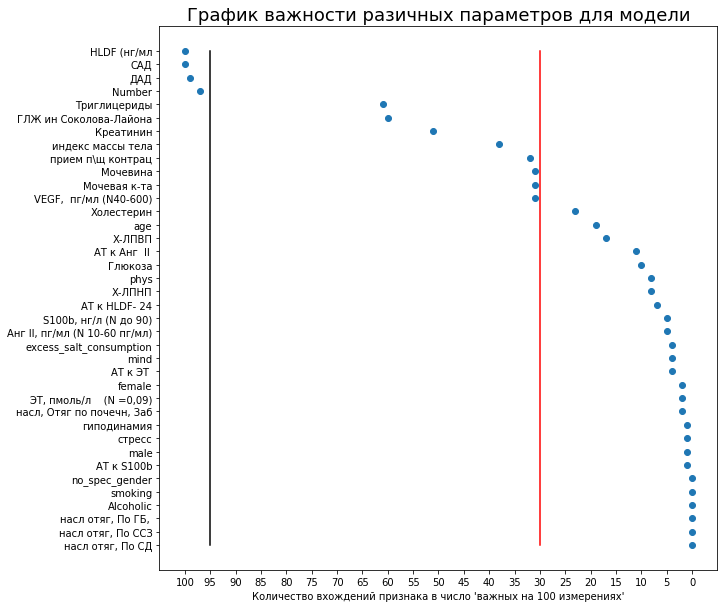

In [69]:
fig = plt.figure(figsize=[10, 10])

plt.scatter(percentile, saves)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.xticks(np.arange(21) * 5)
plt.plot([95, 95], ["насл отяг, По СД", "HLDF (нг/мл"], color='black')
plt.plot([30, 30], ["насл отяг, По СД", "HLDF (нг/мл"], color='red')

plt.title("График важности разичных параметров для модели", fontsize=18)
plt.xlabel("Количество вхождений признака в число 'важных на 100 измерениях'")

plt.savefig("Feature_importance.png")

plt.show()